## 1. Load Data

#### 1.1 Import images

In [4]:
from scripts.deepgtav.messages import frame2numpy
import numpy as np
import pickle
import bunch
import gzip
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

# open the file
filepath = os.path.join(os.getcwd(), 'data')
filename = "dataset_mini.pz"
pfile = gzip.open(os.path.join(filepath, filename), mode='rb')

In [5]:
def apply_pca(image, dim=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.matrix(image)
    #U, S, V = np.linalg.svd(image)
    #reconst = np.matrix(U[:, :dim]) * np.diag(S[:dim]) * np.matrix(V[:dim, :])
    #reconst = reconst[...,None]
    image = image[...,None]
    return image

[(150, 200, 1), (75, 100, 3)]
dict_keys(['direction', 'throttle', 'brake', 'steering', 'speed', 'yawRate', 'location', 'minimap', 'frame'])


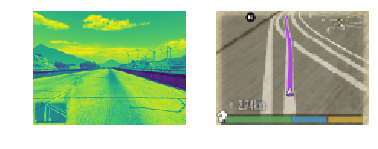

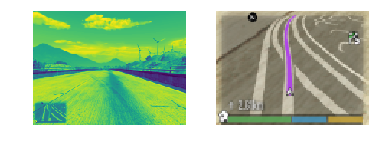

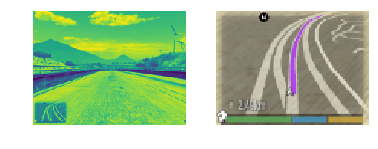

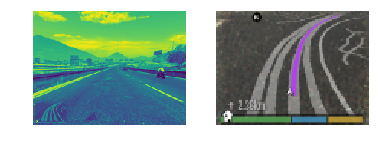

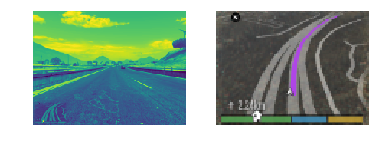

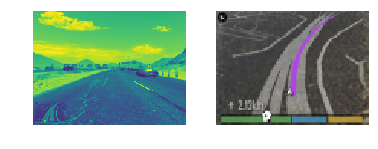

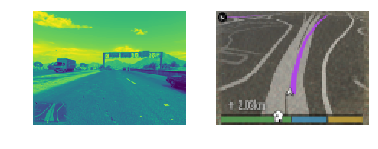

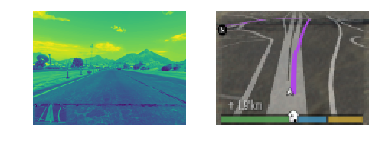

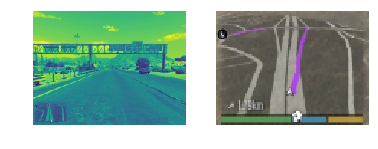

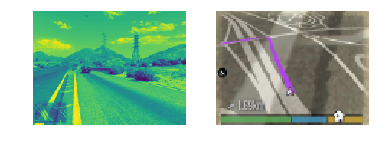

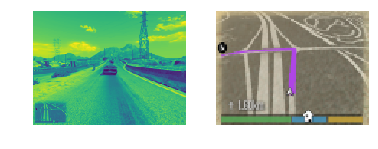

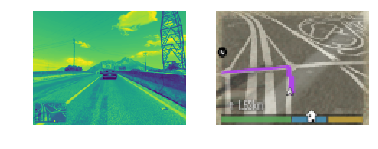

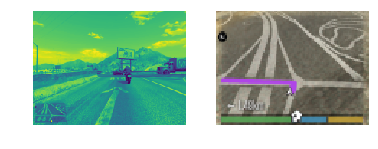

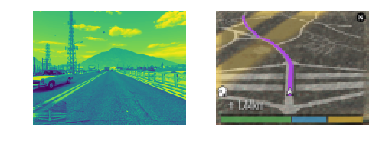

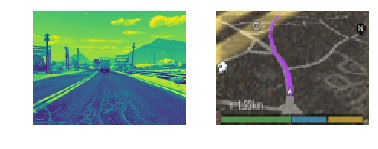

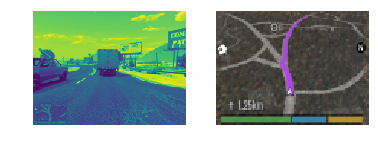

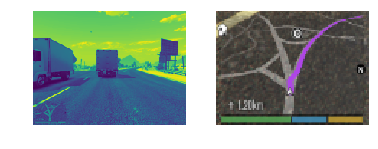

In [9]:
count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (100, 75)     # required image size
minimap_size = (170, 110)  # current minimaps size

images = []
minimaps = []
outputs = []
speeds = []
yawRates = []

# find resize ratio
diff = []
diff.append(minimap_size[0] - image_size[0])
diff.append(minimap_size[1] - image_size[1])
ratio = 1- (np.min(diff) / minimap_size[np.argmin(diff)])

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image, minmap and steering
        image = var['frame']
        image = cv2.resize(image, (200,150))
        image = apply_pca(image, dim=50)
        images.append(image)
        
        minimap = var['minimap']
        minimap = cv2.resize(minimap, (100,75))
        minimap = minimap[:,:,:]
        minimaps.append(minimap)
        
        speeds.append(var['speed'])
        yawRates.append(var['yawRate'])
        # outputs.append([var['steering'], var['throttle'], var['brake']])
        outputs.append([var['steering']])
        
        # Display image
        if count % 100 == 0:
            plt.subplot(121); plt.imshow(image[:,:,0]); plt.axis('off')
            plt.subplot(122); plt.imshow(minimap[:,:,::-1]); plt.axis('off')
            plt.show()
        
        if count == 1: print([image.shape, minimap.shape]); print(var.keys())
        if count>5000: break
            
    except EOFError: break

In [10]:
var['minimap'].shape

(110, 170, 3)

In [11]:
y = np.array(outputs)[:,0]
print(y.shape)

(1700,)


In [12]:
pick_last_steering = 8
holder = np.zeros((y.shape[0], pick_last_steering))
gamma = 0.8
for i in range(holder.shape[0]):
    count = 0
    for j in range(i, i-pick_last_steering, -1):
        holder[i][count] = y[j-pick_last_steering]*(j>0)#*(gamma**(j-pick_last_steering))
        count += 1
print(holder.shape)

(1700, 8)


In [13]:
images = np.array(images)
minimaps = np.array(minimaps)
speeds = np.array(speeds)
yawRates = np.array(yawRates)
holder = np.array(holder)

# Get inputs and outputs
# x = {}
# x.images = images
# x.minimaps = minimaps
# x = np.concatenate((images, minimaps), axis=1)
# x = [images, minimaps, speeds, yawRates, holder]
x = [images, minimaps, holder, speeds, yawRates]

x_shape = [entity.shape for entity in x]
print('Dataset Shape: x: {} | y: {}'.format(x_shape, y.shape))

Dataset Shape: x: [(1700, 150, 200, 1), (1700, 75, 100, 3), (1700, 8), (1700,), (1700,)] | y: (1700,)


## 2. Preprocess Data

#### 2.1 Normalize images to [-1,1]

In [14]:
print([[np.min(entity), np.max(entity)] for entity in x])
if not isinstance(x, np.ndarray): 
    x_new = [(entity/255) for i, entity in enumerate(x) if i<2]
    if len(x)>=2: x_new = [*x_new, *x[2:]]
    x = x_new
[[np.min(entity), np.max(entity)] for entity in x]

[[16, 255], [0, 255], [-1.0026761244002103, 0.2947670162260153], [3.061399459838867, 20.00408363342285], [-23.229126735111457, 106.39901349410498]]


[[0.06274509803921569, 1.0],
 [0.0, 1.0],
 [-1.0026761244002103, 0.2947670162260153],
 [3.061399459838867, 20.00408363342285],
 [-23.229126735111457, 106.39901349410498]]

In [15]:
print(np.min(y), np.max(y))
np.clip(y, -1, 1, out=y)
print(np.min(y), np.max(y))

-1.0026761244002103 0.2947670162260153
-1.0 0.2947670162260153


#### 2.4 Split data for train and test

In [16]:
seed = 1
np.random.seed(seed)

recv = [None for i in range(2*len(x))]
from sklearn.model_selection import train_test_split
*recv, y_train, y_test = train_test_split(*x, y, test_size=0.2, random_state=np.random, shuffle=True)

x_train = recv[::2]
x_test = recv[1::2]

# print("Train Data | Test Data")
# x_train = [x0_train, x1_train]
# x_test = [x0_test, x1_test]
print(("{0:^10} | {1:^10}").format(x_train[0].shape[0], x_test[0].shape[0]))

   1360    |    340    


## 3. Build Model

#### 3.1 Import Keras and use NCHW mode

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.metrics import mae
from keras.initializers import RandomNormal
from keras.regularizers import Regularizer

from keras import backend
backend.set_image_dim_ordering('tf')

Using TensorFlow backend.


#### 3.2 Create reusable functions

In [18]:
import keras.backend as K

h = x[0].shape[1]
w = x[0].shape[2]
#c = x[0].shape[3]
no_of_classes = y.shape[0]
#print(x.shape, y.shape)

def evaluate_model(model):
    print("\n\n")
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: ", scores[1]*100, "%")
    return scores

def accuracy_metric(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))


In [19]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class ScaleLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ScaleLayer, self).__init__(**kwargs)
    def call(self, x):
        return (x-0.5)*2
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#### 3.3 Create a baseline model

In [ ]:
def baseline_model():
    
    # Level 1
    image = Input(shape=(h,w,c))
    conv_1_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)
    conv_1_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1_1)
    pool_1_1 = MaxPooling2D(pool_size=(2, 2))(conv_1_2)
    
    # Level 2
    conv_2_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1_1)
    conv_2_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2_1)
    pool_2_1 = MaxPooling2D(pool_size=(2, 2))(conv_2_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2_1)
    conv_3a_2 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)
    conv_3a_3 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1])
    dense_4_1 = Dense(4096, kernel_initializer='normal', activation='tanh')(concat_4_1)
    dense_4_2 = Dense(2048, kernel_initializer='normal', activation='tanh')(dense_4_1)
    dense_4_3 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_2)

    model = Model(inputs=[image, prev_steering], outputs=dense_4_3)
    model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=[mae,'accuracy'])
    return model

In [ ]:
def image_map_steering_concat_model(channels=3):

    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels
    
    # Level 1a
    image = Input(shape=(h,w,c))
    conv_1a_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)#64
    conv_1a_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    conv_3a_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    conv_3a_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)
    
    # Level 1c
    maps = Input(shape=(h,w,c))
    conv_1c_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(maps)
    conv_1c_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    conv_3c_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    conv_3c_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    conv_3c_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_3c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(100, kernel_initializer='normal', activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(60, kernel_initializer='normal', activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(40, kernel_initializer='normal', activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', activation='tanh')(dense_4_3)#512
    dense_4_5 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_4)#

    model = Model(inputs=[image, maps, prev_steering], outputs=dense_4_5)
    model.compile(loss='mse', optimizer=Adam(lr=0.00005), metrics=[mae,'accuracy'])
    return model

In [ ]:
def image_map_steering_yaw_concat_model(channels=3):

    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels
    
    # Level 1a
    image = Input(shape=(h,w,c))
    conv_1a_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)#64
    conv_1a_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    #conv_3a_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    #conv_3a_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    #conv_3a_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    #pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_2a_1)
    
    c = 3
    
    # Level 1c
    maps = Input(shape=(h,w,c))
    conv_1c_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(maps)
    conv_1c_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    #conv_3c_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    #conv_3c_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    #conv_3c_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    #pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_2c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(500, kernel_initializer='normal', activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(250, kernel_initializer='normal', activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(50, kernel_initializer='normal', activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', activation='tanh')(dense_4_3)#512
    
    #Level 5
    speed_input = Input(shape=(1,))
    yaw_input = Input(shape=(1,))
    concat_5_1 = concatenate([dense_4_4, speed_input, yaw_input])
    dense_5_1 = Dense(5, kernel_initializer='normal', activation='tanh')(concat_5_1)
    dense_5_2 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_5_1)
    
    model = Model(inputs=[image, maps, prev_steering, speed_input, yaw_input], outputs=dense_5_2)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=[mae,accuracy_metric])
    return model

In [20]:
from keras import regularizers

def image_map_steering_yaw_concat_regularised_model(channels=3):

    h1 = 150         # height of the image
    w1 = 200         # width of the image
    c1 = 1
    
    # Level 1a
    image = Input(shape=(h1,w1,c1))
    conv_1a_1 = Conv2D(6, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_1a_1', input_shape=(h1,w1,c1))(image)#64
    conv_1a_2 = Conv2D(6, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_1a_2')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(10, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_2a_1')(pool_1a_1)#128
    conv_2a_2 = Conv2D(10, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_2a_2')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3a_1')(pool_2a_1)#256
    conv_3a_2 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3a_2')(conv_3a_1)#256
    conv_3a_3 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3a_3')(conv_3a_2)#256
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)
    
    h2 = 75          # height of the image
    w2 = 100         # width of the image
    c2 = 3
    
    # Level 1c
    maps = Input(shape=(h2,w2,c2))
    conv_1c_1 = Conv2D(6, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_1c_1', input_shape=(h2,w2,c2))(maps)
    conv_1c_2 = Conv2D(6, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_1c_2')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(10, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_2c_1')(pool_1c_1)
    conv_2c_2 = Conv2D(10, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_2c_2')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    conv_3c_1 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3c_1')(pool_2c_1)
    conv_3c_2 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3c_2')(conv_3c_1)
    conv_3c_3 = Conv2D(24, kernel_size=3, kernel_initializer='normal', activation='relu', name='conv_3c_3')(conv_3c_2)
    pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_3c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(200, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')(concat_4_1)#8192
    dense_4_2 = Dense(100, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')(dense_4_1)#4096
    dense_4_3 = Dense(50, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')(dense_4_3)#512
    
    #Level 5
    speed_input = Input(shape=(1,))
    yaw_input = Input(shape=(1,))
    concat_5_1 = concatenate([dense_4_4, speed_input, yaw_input])
    dense_5_1 = Dense(5, kernel_initializer='normal', activation='relu')(concat_5_1)
    dense_5_2 = Dense(1, activation='sigmoid')(dense_5_1)
    output = ScaleLayer(1)(dense_5_2)
    
    model = Model(inputs=[image, maps, prev_steering, speed_input, yaw_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=[accuracy_metric])
    return model

In [21]:
#model = image_map_steering_concat_model(channels=3)#baseline_model()
model = image_map_steering_yaw_concat_regularised_model(channels=1)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 200, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv_1a_1 (Conv2D)              (None, 148, 198, 6)  60          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1c_1 (Conv2D)              (None, 73, 98, 6)    168         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1a_2 

In [22]:
print(len(x_train))

5


In [23]:
model.fit(x_train, y_train, validation_split=0.1, epochs=2, batch_size=25)
evaluate_model(model)

Train on 1224 samples, validate on 136 samples
Epoch 1/2
1224/1224 [==============================] - 54s 44ms/step - loss: 19.3623 - accuracy_metric: 0.0277 - val_loss: 7.3854 - val_accuracy_metric: 0.0186
Epoch 2/2
1224/1224 [==============================] - 25s 20ms/step - loss: 3.7094 - accuracy_metric: 0.0131 - val_loss: 1.4799 - val_accuracy_metric: 0.0168



340/340 [==============================] - 3s 9ms/step
Accuracy:  1.3480954759699455 %


[1.478629591885735, 0.013480954759699456]

In [24]:
for layer in model.layers:
    print(layer.name)

input_1
input_2
conv_1a_1
conv_1c_1
conv_1a_2
conv_1c_2
max_pooling2d_1
max_pooling2d_4
conv_2a_1
conv_2c_1
conv_2a_2
conv_2c_2
max_pooling2d_2
max_pooling2d_5
conv_3a_1
conv_3c_1
conv_3a_2
conv_3c_2
conv_3a_3
conv_3c_3
max_pooling2d_3
input_3
max_pooling2d_6
flatten_1
dense_1
flatten_2
concatenate_1
dense_2
dense_3
dense_4
dense_5
input_4
input_5
concatenate_2
dense_6
dense_7
scale_layer_1


In [32]:
layer_name = 'scale_layer_1'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test)

layer_name2 = 'dense_7'
intermediate_layer_model2 = Model(inputs=model.input, outputs=model.get_layer(layer_name2).output)
intermediate_output2 = intermediate_layer_model2.predict(x_test)

In [33]:
im = intermediate_output
im2 = intermediate_output2
print(im.shape, im2.shape)
#for i in range(24):
#    plt.subplot(121); plt.imshow(im[:,:,i]); plt.axis('off')
#    plt.subplot(122); plt.imshow(im2[:,:,0]); plt.axis('off')
#    plt.show()
for i in range(len(im)):
    print(im[i], im2[i])

(340, 1) (340, 1)
[-0.01201248] [0.49399376]
[-0.00129795] [0.49935102]
[0.00442803] [0.502214]
[0.00465775] [0.5023289]
[0.01273417] [0.5063671]
[0.01160085] [0.5058004]
[-0.00562304] [0.49718848]
[0.010391] [0.5051955]
[-0.26760614] [0.36619693]
[0.01719415] [0.5085971]
[0.01096666] [0.5054833]
[-0.02014214] [0.48992893]
[-0.00541413] [0.49729294]
[0.00815952] [0.50407976]
[-0.9501973] [0.02490137]
[0.00783634] [0.5039182]
[-0.01690847] [0.49154577]
[0.05546629] [0.52773315]
[-0.00764346] [0.49617827]
[-0.01930386] [0.49034807]
[0.00846398] [0.504232]
[0.00012231] [0.50006115]
[0.00674021] [0.5033701]
[0.00185549] [0.50092775]
[0.01848161] [0.5092408]
[-0.01260918] [0.4936954]
[-0.00985098] [0.4950745]
[0.01974893] [0.50987446]
[-0.01456732] [0.49271634]
[0.00280452] [0.50140226]
[-0.00180298] [0.4990985]
[-0.00275838] [0.4986208]
[0.00633502] [0.5031675]
[0.0178858] [0.5089429]
[-0.00256974] [0.49871513]
[0.01825118] [0.5091256]
[-0.00747967] [0.49626017]
[0.0178237] [0.50891185]
[0

In [ ]:
model.predict(x_train[:10])

In [ ]:
y_train[:10]

## 4. Saving and loading model architecture and weights

#### 4.1 Define reusable functions

In [ ]:
import h5py
from keras.models import model_from_json
from keras.models import load_model

path_models = os.path.join(os.getcwd(), 'models')
valid_model_files = [".h5", ".json"]
weights_suffix = '_weights.h5'
architecture_suffix = '_architecture.json'

In [ ]:
def get_last_file_number(path):
    numbers = [-1]
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_model_files: continue
        if filename.startswith('model_'): 
            numbers.append(int(''.join(list(filter(str.isdigit, filename)))))
    counter = max(numbers)
    return counter

#### 4.2 Save current model

In [ ]:
counter = 0
if not os.path.isdir(path_models): os.makedirs(path_models)
else: counter = get_last_file_number(path_models) + 1

model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + weights_suffix
with open(model_arch_file, 'w+') as json_file:
    json_file.write(model.to_json(indent=4))
# model.save_weights(model_weights_file)

model.save(path_models + '\\' + model_name + '.h5')

print("Saving files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

#### 4.3 Load model from file

In [ ]:
counter = get_last_file_number(path_models)
    
model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + architecture_suffix

print("Loading files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

if not os.path.isfile(model_arch_file):
    print('Could not find', model_arch_file)
elif not os.path.isfile(model_weights_file):
    print('Could not find', model_weights_file)
else:
    # with open(model_arch_file, 'r') as json_file:
        # model_loaded = model_from_json(json_file.read())
    # model_loaded.load_weights(model_weights_file)
    model_loaded = load_model(path_models + '\\' + model_name + '.h5')

In [ ]:
evaluate_model(model_loaded)